# Preprocessing

### Installing and Importing Packages

In [4]:
import datetime
import pandas as pd
#import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import numpy as np
import matplotlib.pyplot as plt
#import geopandas as gpd
from dateutil.parser import parse
from google.colab import drive


In [5]:
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, plot_roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [6]:
drive.mount('/content/drive')

Mounted at /content/drive


### Reading and Cleaning Base Dataframes

In [ ]:
acs = pd.read_csv('/content/drive/My Drive/ACS_taxizone_cluster.csv')

In [ ]:
acs.groupby('cluster').mean()

,LocationID,race_white,transit_commute,transit_12_5,transit_60min+,hh_median_income,essential_workers
cluster,,,,,,,
0,134.461538,11779.219780,5318.175824,98.252747,1691.340659,82708.192878,2219.258242
1,131.250000,19123.671053,17153.921053,563.842105,6757.618421,55538.256355,8216.815789
2,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
FHV = pd.read_csv('/content/drive/My Drive/FHV_ridership_dummies_no_acs.csv')
FHV['PUTime'] = pd.to_datetime(FHV['PUTime'])

In [ ]:
FHV = FHV[~((FHV['PULocationID'] == 1) | (FHV['DOLocationID'] == 1))] # Drop all trips to and from Newark
FHV = FHV[~((FHV['PULocationID'] == 132) | (FHV['DOLocationID'] == 132))] # Drop all trips to and from JFK
FHV = FHV[~((FHV['PULocationID'] == 138) | (FHV['DOLocationID'] == 138))] # Drop all trips to and from LaGuardia

In [ ]:
FHV = FHV.drop(columns=['PUTime','DOTime'])
FHV = FHV.dropna()

In [ ]:
bus_stops = pd.read_csv('/content/drive/My Drive/FHV_bus_stops.csv')
bus_stops = bus_stops.merge(pd.DataFrame(list(range(1,266))), left_on='LocationID', right_on=0, how='right')
bus_stops = bus_stops.fillna(0).iloc[:,:-1]

In [ ]:
acs = acs.rename(columns={'cluster':'acs_cluster'})

NameError: ignored

In [ ]:
acs_pca = pd.read_csv('/content/drive/My Drive/FHV_ACS_principal_component.csv')



# Clustering Pickup and Dropoff Locations


In [ ]:
np.setdiff1d(range(2,266), FHV.PULocationID.unique())

array([ 57, 103, 104, 105, 264, 265])

In [ ]:
np.setdiff1d(range(2,266), acs.LocationID.unique())

array([ 57, 104, 105, 264, 265])

### Clustering PU Locations By Mobility Data Only

In [ ]:
## create ride count

ride_count = FHV[['PULocationID','Duration']].groupby('PULocationID').count().reset_index()
ride_count.columns = ['LocationID','ride_count']

In [ ]:
FHV_PULoc1 = FHV.groupby('PULocationID', as_index=False).sum().drop(columns=['DOLocationID','subway_y'])
FHV_PULoc1 = FHV_PULoc1.merge(ride_count, left_on='PULocationID', right_on='LocationID').drop(columns='LocationID')
FHV_PULoc1 = FHV_PULoc1.merge(bus_stops, left_on=FHV_PULoc1.index, right_on='LocationID').drop(columns='LocationID')
FHV_PULoc1 = FHV_PULoc1.drop(columns='Duration')

In [ ]:
scaler = StandardScaler()
scaled_PULoc = scaler.fit_transform(FHV_PULoc1.iloc[:,1:])

In [ ]:
##  KMeans Clustering Mobility Data Only

for n_clusters in range(2,13):
    km = KMeans(random_state=1234 ,n_clusters=n_clusters)
    res= km.fit(scaled_PULoc)   
    cluster_labels = res.labels_
    silhouette_avg = silhouette_score(scaled_PULoc, cluster_labels)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}, inertia is: {}".format(silhouette_avg, res.inertia_))

For n_clusters = 2, the average silhouette_score is : 0.5027389171190045, inertia is: 1713.2534648084547
For n_clusters = 3, the average silhouette_score is : 0.4706810950597852, inertia is: 1062.2244992483465
For n_clusters = 4, the average silhouette_score is : 0.44313571022018877, inertia is: 792.7612737211351
For n_clusters = 5, the average silhouette_score is : 0.4499856984591296, inertia is: 691.6528082530886
For n_clusters = 6, the average silhouette_score is : 0.44289269921080904, inertia is: 589.3661572854886
For n_clusters = 7, the average silhouette_score is : 0.3801788661009662, inertia is: 505.9647312006864
For n_clusters = 8, the average silhouette_score is : 0.4320974902313362, inertia is: 442.2381124659853
For n_clusters = 9, the average silhouette_score is : 0.4071935153450129, inertia is: 379.9954382536933
For n_clusters = 10, the average silhouette_score is : 0.39082884543219265, inertia is: 346.2138932268573
For n_clusters = 11, the average silhouette_score is : 0.3

In [ ]:
km = KMeans(random_state=1234 ,n_clusters=5)
res= km.fit(scaled_PULoc)   
FHV_PULoc1['PU_cluster'] = res.labels_

In [ ]:
PU_Mobility = FHV_PULoc1 
PU_Mobility.to_csv('PO_Mobility_counts.csv')

In [ ]:
PU_Mobility.groupby('PU_cluster').mean()
PU_Mobility.groupby('PU_cluster').mean().to_csv('PU_Mobility_clusters.csv', index=False)

### Clustering DO Locations By Mobility Data Only

In [ ]:
FHV_DOLoc1 = FHV.groupby('DOLocationID', as_index=False).sum().drop(columns=['PULocationID','subway_x'])
FHV_DOLoc1 = FHV_DOLoc1.merge(ride_count, left_on='DOLocationID', right_on='LocationID').drop(columns='LocationID')
FHV_DOLoc1 = FHV_DOLoc1.merge(bus_stops, left_on=FHV_DOLoc1.index, right_on='LocationID').drop(columns='LocationID')
FHV_DOLoc1 = FHV_DOLoc1.drop(columns='Duration')

In [ ]:
scaler = StandardScaler()
scaled_DOLoc = scaler.fit_transform(FHV_DOLoc1.iloc[:,1:])

In [ ]:
##  KMeans Clustering Mobility Data Only

for n_clusters in range(2,13):
    km = KMeans(random_state=1234 ,n_clusters=n_clusters)
    res= km.fit(scaled_DOLoc)   
    cluster_labels = res.labels_
    silhouette_avg = silhouette_score(scaled_DOLoc, cluster_labels)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}, inertia is: {}".format(silhouette_avg, res.inertia_))

For n_clusters = 2, the average silhouette_score is : 0.5168380184008025, inertia is: 1696.2819200779838
For n_clusters = 3, the average silhouette_score is : 0.47197667008701827, inertia is: 1082.820538035397
For n_clusters = 4, the average silhouette_score is : 0.4361855181222415, inertia is: 816.9777263529147
For n_clusters = 5, the average silhouette_score is : 0.4424464103695726, inertia is: 700.3883134754899
For n_clusters = 6, the average silhouette_score is : 0.35730728127134403, inertia is: 609.0905137389025
For n_clusters = 7, the average silhouette_score is : 0.3959112033677949, inertia is: 513.1422522647424
For n_clusters = 8, the average silhouette_score is : 0.4087434999719403, inertia is: 445.57494818606506
For n_clusters = 9, the average silhouette_score is : 0.39446208065543054, inertia is: 399.451552808098
For n_clusters = 10, the average silhouette_score is : 0.39057968512773, inertia is: 362.28214767861544
For n_clusters = 11, the average silhouette_score is : 0.388

In [ ]:
km = KMeans(random_state=1234 ,n_clusters=5)
res= km.fit(scaled_DOLoc)   
FHV_DOLoc1['DO_cluster'] = res.labels_

In [ ]:
DO_Mobility = FHV_DOLoc1
DO_Mobility.to_csv('DO_Mobility_counts.csv')

In [ ]:
DO_Mobility.groupby('DO_cluster').mean().to_csv('DO_Mobility_clusters.csv', index=False)
DO_Mobility.groupby('DO_cluster').mean()

,DOLocationID,overnight,subway_y,0,1,2,3,4,5,6,Lyft,Uber,Via,ride_count,bus_stop_count
DO_cluster,,,,,,,,,,,,,,,
0,149.113636,9697.329545,132774.170455,18480.306818,17766.136364,19347.465909,19948.102273,21901.761364,21176.511364,18337.511364,36764.500000,97281.556818,2911.738636,138136.125000,0.261364
1,123.789916,2947.403361,31605.907563,5519.126050,5233.563025,5615.630252,5793.369748,6388.235294,6489.403361,5638.697479,11210.756303,28958.243697,509.025210,40477.596639,0.285714
2,96.818182,32543.727273,362183.090909,47985.545455,45408.545455,49159.272727,50717.909091,57483.000000,58700.818182,52728.000000,112388.272727,242791.454545,7003.363636,366438.454545,0.000000
3,139.236842,20761.552632,227306.631579,30484.736842,28764.526316,31520.394737,32766.421053,37495.184211,37967.105263,33301.026316,65673.342105,163240.210526,3385.842105,230946.868421,0.657895
4,68.500000,55699.500000,598483.000000,78025.500000,74273.000000,81087.000000,84035.500000,95611.500000,98947.500000,86503.000000,196379.500000,395894.000000,6209.500000,592410.000000,1.000000


# Split Dataset into smaller random samples for testing


In [ ]:
##FHV_sub1, FHV_sub2 = train_test_split(FHV ,random_state=1234,test_size=0.4)

#### Merge Zone Clusters, ACS PCA and bus stop counts with ride data

In [ ]:
# Merge Taxi Zone clusters with FHV ride data

FHV_full = FHV.merge(PU_Mobility[['PULocationID','PU_cluster']], on='PULocationID', how='left')\
    .merge(DO_Mobility[['DOLocationID','DO_cluster']], on='DOLocationID', how='left')

In [ ]:
# add overnight bus stop count

FHV_full = FHV_full.merge(bus_stops, left_on='PULocationID', right_on='LocationID', how='left').drop(columns='LocationID')\
    .merge(bus_stops, left_on='DOLocationID', right_on='LocationID', how='left').drop(columns='LocationID')


In [ ]:
# Merge ACS PCA with FHV ride data

FHV_full = FHV_full.merge(acs_pca[['LocationID','PCA']], left_on='PULocationID', right_on='LocationID', how='left').drop(columns='LocationID')\
    .merge(acs_pca[['LocationID','PCA']], left_on='DOLocationID', right_on='LocationID', how='left').drop(columns='LocationID')

In [ ]:
FHV_full = FHV_full.join(pd.get_dummies(FHV_full['PU_cluster'], prefix='PU_cluster_'))\
    .join(pd.get_dummies(FHV_full['DO_cluster'], prefix='DO_cluster_')).drop(columns=['PU_cluster','DO_cluster'])

In [ ]:
FHV_full.dropna(inplace=True)

In [ ]:
FHV_full = FHV_full.rename(columns={'0':'Mon','1':'Tue','2':'Wed','3':'Thu','4':'Fri','5':'Sat', '6':'Sun'})

In [ ]:
FHV_merged, FHV_merged2 = train_test_split(FHV_full ,random_state=1234,test_size=0.4)

In [ ]:
FHV_merged.to_csv('FHV_PreProcessed_RandomSamp.csv', index=False)

In [ ]:
FHV_merged2.to_csv("FHV_PreProcessed_RandomSamp2.csv", index=False)

# Feature Selection and Modelling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
import seaborn as sns
from google.colab import drive

import xgboost
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, plot_roc_curve
from sklearn.preprocessing import StandardScaler

In [ ]:
drive.mount('/content/drive')

In [33]:
FHV_merged = pd.read_csv('/content/drive/My Drive/FHV_PreProcessed_RandomSamp.csv')

In [34]:
FHV_merged = FHV_merged[~((FHV_merged['PULocationID'] == 1) | (FHV_merged['DOLocationID'] == 1))] # Drop all trips to and from Newark
FHV_merged = FHV_merged[~((FHV_merged['PULocationID'] == 132) | (FHV_merged['DOLocationID'] == 132))] # Drop all trips to and from JFK
FHV_merged = FHV_merged[~((FHV_merged['PULocationID'] == 138) | (FHV_merged['DOLocationID'] == 138))] # Drop all trips to and from LaGuardia

Text(0.5, 1.0, 'FHV Ride Count for Training/Validation Set')

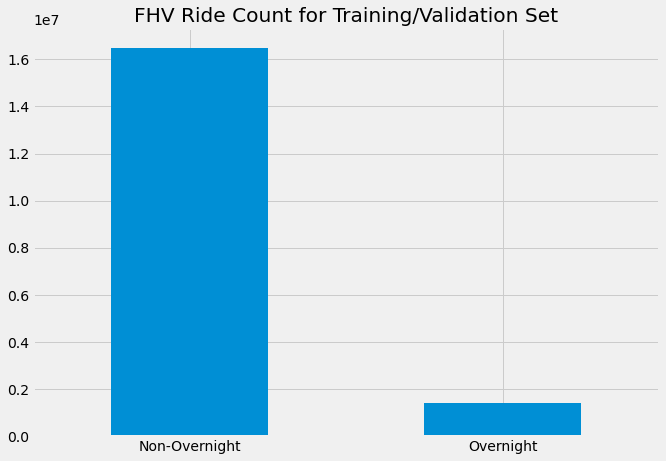

In [60]:
fig, ax = plt.subplots(figsize=(10,7))
FHV_merged.overnight.value_counts().plot.bar(ax=ax)
ax.set_xticks([0,1])
ax.set_xticklabels(['Non-Overnight','Overnight'], rotation=0)
plt.title('FHV Ride Count for Training/Validation Set')

In [ ]:
#FHV_merged.to_csv('FHV_PreProcessed_RandomSamp.csv', index=False)

In [ ]:
# Train-Test Split

X = FHV_merged.drop(columns='overnight')
y = FHV_merged['overnight']

X_train1, X_valid1, y_train1, y_valid1 = train_test_split(X,y,random_state=1234,test_size=0.4)

In [ ]:
## Standardizing the Data
scaler = StandardScaler()
scale = scaler.fit(X_train1.drop(columns=['PULocationID','DOLocationID']))
XS_train1 = scale.transform(X_train1.drop(columns=['PULocationID','DOLocationID']))
XS_valid1 = scale.transform(X_valid1.drop(columns=['PULocationID','DOLocationID']))

In [ ]:
#Logistic Classifier

lm = LogisticRegression()
lm.fit(XS_train1, y_train1)

y_pred = lm.predict(XS_valid1)
pred_proba=lm.predict_proba(XS_valid1)[:,1] # predicted probability of y = 1
AUC_OS = roc_auc_score(np.array(y_valid1),pred_proba)

print('In Sample Accuracy:',lm.score(XS_train1,y_train1))
print('Out Of Sample Accuracy:',lm.score(XS_valid1,y_valid1))
print('\n')
print('Out Of Sample Precision:',precision_score(y_valid1, y_pred))
print('Out Of Sample Recall:', recall_score(y_valid1, y_pred))
print('Out Of Sample F1 Score:',f1_score(y_valid1, y_pred))
print('Out of Sample ROC AUC Score:,',AUC_OS)

In Sample Accuracy: 0.9200358478732052
Out Of Sample Accuracy: 0.9199859630725032




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Out Of Sample Precision: 0.0
Out Of Sample Recall: 0.0
Out Of Sample F1 Score: 0.0
Out of Sample ROC AUC Score:, 0.6227071741366956


## Random Undersampling

In [9]:
# Undersample the Non-Overnight rides to better balance target variable
from imblearn.under_sampling import RandomUnderSampler

X = FHV_merged.drop(columns='overnight')
y = FHV_merged['overnight']

undersample = RandomUnderSampler(sampling_strategy=0.8)
X_rs, y_rs = undersample.fit_resample(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


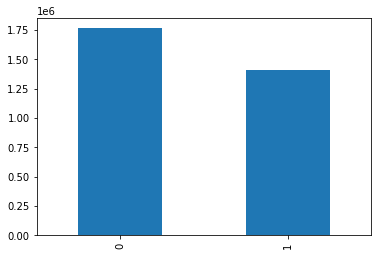

In [10]:
pd.Series(y_rs).value_counts().plot.bar()

In [11]:
pd.Series(y_rs).value_counts(normalize=True)

0    0.555555
1    0.444445
dtype: float64

In [ ]:
resamp_weights = weights = pd.Series(y_rs).value_counts(normalize=True).to_dict()
resamp_weights[1]

0.44444447816620525

## Resplit Training and Validation Data

In [12]:
X_rs = pd.DataFrame(X_rs, columns=X.columns)

In [13]:
# Train Test Split the undersampled data

X_train, X_valid, y_train, y_valid = train_test_split(X_rs,y_rs,random_state=1234,test_size=0.4)

In [14]:
## Standardizing the Data
scaler = StandardScaler()
scale = scaler.fit(X_train.drop(columns=['PULocationID','DOLocationID']))
XS_train = scale.transform(X_train.drop(columns=['PULocationID','DOLocationID']))
XS_valid = scale.transform(X_valid.drop(columns=['PULocationID','DOLocationID']))

In [ ]:
### Select Features 

sel = SelectFromModel(RandomForestClassifier(n_estimators = 100), threshold=0.2)
sel.fit(XS_train, y_train)

selected_feat= X_train.columns[(sel.get_support())]
selected_feat

KeyboardInterrupt: ignored

##Logistic Classifier

In [ ]:
#Logistic Classifier

lm = LogisticRegression()
lm.fit(XS_train, y_train)

y_pred = lm.predict(XS_valid)
pred_proba=lm.predict_proba(XS_valid)[:,1] # predicted probability of y = 1
AUC_OS = roc_auc_score(np.array(y_valid),pred_proba)

print('In Sample Accuracy:',lm.score(XS_train,y_train))
print('Out Of Sample Accuracy:',lm.score(XS_valid,y_valid))
print('\n')
print('Out Of Sample Precision:',precision_score(y_valid, y_pred))
print('Out Of Sample Recall:', recall_score(y_valid, y_pred))
print('Out Of Sample F1 Score:',f1_score(y_valid, y_pred))
print('Out of Sample ROC AUC Score:,',AUC_OS)

In Sample Accuracy: 0.5996686365953591
Out Of Sample Accuracy: 0.5999361189257909


Out Of Sample Precision: 0.578349098108227
Out Of Sample Recall: 0.3719342049887359
Out Of Sample F1 Score: 0.45272354319980546
Out of Sample ROC AUC Score:, 0.6249026020595524


In [ ]:
1.0*sum((pred_proba>0.5)==y_valid)/len(y_valid)

0.5981817407547652

ValueError: ignored

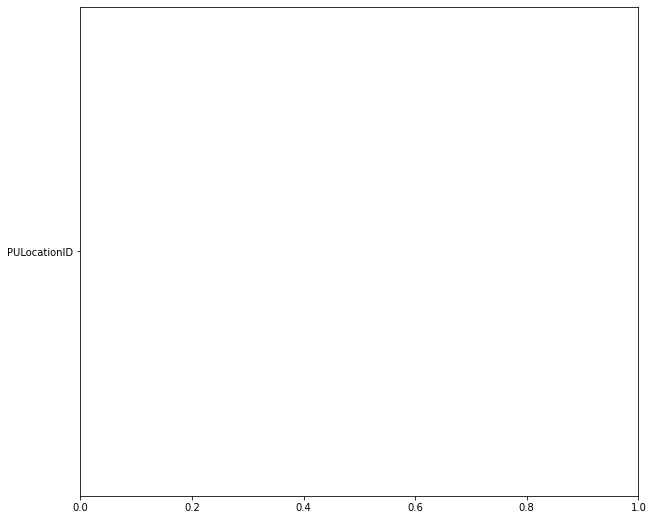

In [ ]:
plt.rcParams["figure.figsize"] = (10,9)

plt.barh(X_train.columns, lm.coef_[0])
plt.title('Logistic Regression Coefficients', fontsize=15)

In [ ]:
# GridSearch for best LogClassifier parameters

param_grid = {'C':np.logspace(1e-5,1e5, 20)}

lm = LogisticRegression()
gs = GridSearchCV(lm,param_grid=param_grid,scoring='accuracy')
rs = gs.fit(XS_train,y_train)
pred=rs.predict(XS_valid)
print(rs.best_params_)
print(accuracy_score(np.array(y_valid),pred))

/usr/local/lib/python3.7/dist-packages/numpy/core/function_base.py:265: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)


{'C': 1.0000230261160268}
0.5965427983790124


## Decision Tree Classifier

In [ ]:
# Decision Tree Classifier

dt=DecisionTreeClassifier()
dt.fit(XS_train,y_train)

y_pred = dt.predict(XS_valid)

pred_proba=dt.predict_proba(XS_valid)[:,1] # predicted probability of y = 1
AUC_OS = roc_auc_score(np.array(y_valid),pred_proba)


print('In Sample Accuracy:',dt.score(XS_train,y_train))
print('Out Of Sample Accuracy:',dt.score(XS_valid,y_valid))
print('\n')
print('Out Of Sample Precision:',precision_score(y_valid, y_pred))
print('Out Of Sample Recall:', recall_score(y_valid, y_pred))
print('Out Of Sample F1 Score:',f1_score(y_valid, y_pred))
print('Out of Sample ROC AUC Score:,',AUC_OS)

In Sample Accuracy: 0.9910123813457329
Out Of Sample Accuracy: 0.5874622791396978


Out Of Sample Precision: 0.49974429067271026
Out Of Sample Recall: 0.49782898224653144
Out Of Sample F1 Score: 0.4987847977944987
Out of Sample ROC AUC Score:, 0.5753690262996471


In [ ]:
plt.barh(X_train.columns, dt.feature_importances_)

NotFittedError: ignored

## Random Forest Classifier

In [15]:
# Random Forest Classifier

rf = RandomForestClassifier(n_estimators=100, max_depth=30, min_samples_split=5,\
                          max_features='sqrt', min_samples_leaf=4, oob_score=True)
rf.fit(XS_train,y_train)

y_pred = rf.predict(XS_valid)

pred_proba=rf.predict_proba(XS_valid)[:,1] # predicted probability of y = 1
AUC_OS = roc_auc_score(np.array(y_valid),pred_proba)


print('In Sample Accuracy:',rf.score(XS_train,y_train))
print('Out Of Sample Accuracy:',rf.score(XS_valid,y_valid))
print('\n')
print('Out Of Sample Precision:',precision_score(y_valid, y_pred))
print('Out Of Sample Recall:', recall_score(y_valid, y_pred))
print('Out Of Sample F1 Score:',f1_score(y_valid, y_pred))
print('Out of Sample ROC AUC Score:',AUC_OS)

In Sample Accuracy: 0.787278120784531
Out Of Sample Accuracy: 0.6427860015482507


Out Of Sample Precision: 0.6142919549046431
Out Of Sample Recall: 0.5296455967491521
Out Of Sample F1 Score: 0.5688370463288016
Out of Sample ROC AUC Score: 0.6929407257406156


Text(0.5, 1.0, 'Random Forest Feature Importance')

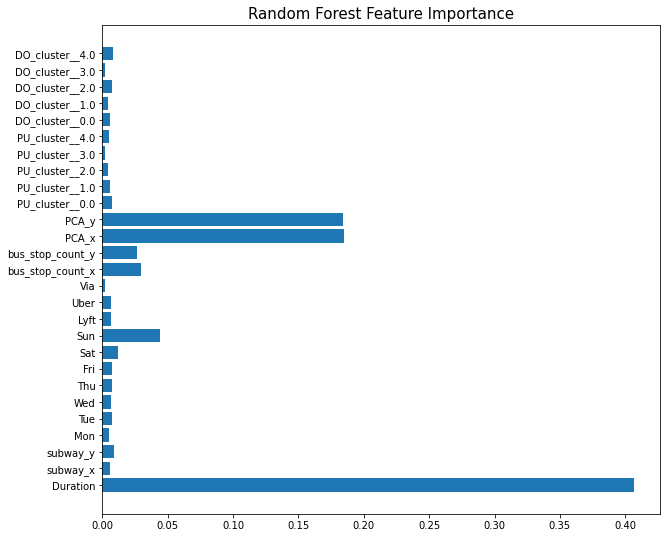

In [ ]:
plt.barh(X_train.columns, rf.feature_importances_)
plt.title('Random Forest Feature Importance', fontsize=15)

In [ ]:
# Randomized for best RF parameters

param_grid = {
              'max_depth':[2,15,30,50],
              'max_features':['auto', 'sqrt'],
              'min_samples_split':[2, 5, 10],
              'min_samples_leaf':[1, 2, 4,10],
}

rf = RandomForestClassifier(n_estimators=30)
gs = RandomizedSearchCV(rf,param_distributions=param_grid,scoring='roc_auc', cv=2, n_jobs=-1, verbose=2)
rs = gs.fit(XS_train,y_train)
pred=rs.predict(XS_valid)
print(rs.best_params_)
print(f1_score(np.array(y_valid),pred))

NameError: ignored

In [ ]:
# GridSearch for best RF parameters

param_grid = {'max_depth':range(2,15)}
rf = RandomForestClassifier(n_estimators=50)
gs = GridSearchCV(rf,param_grid=param_grid,scoring='roc_auc')
rs = gs.fit(XS_train,y_train)
pred=rs.predict(XS_valid)
print(rs.best_params_)
print(f1_score(np.array(y_valid),pred))

KeyboardInterrupt: ignored

## XG Boost Classifier

In [ ]:
#XGBoost

xg = xgboost.XGBClassifier()
xg.fit(XS_train, y_train)

y_pred = xg.predict(XS_valid)
pred_proba= xg.predict_proba(XS_valid)[:,1] # predicted probability of y = 1

print('In Sample Accuracy:',xg.score(XS_train,y_train))
print('Out Of Sample Accuracy:',xg.score(XS_valid,y_valid))
print('\n')
AUC_OS = roc_auc_score(np.array(y_valid),pred_proba)
print('Out Of Sample Precision:',precision_score(y_valid, y_pred))
print('Out Of Sample Recall:', recall_score(y_valid, y_pred))
print('Out Of Sample F1 Score:',f1_score(y_valid, y_pred))
print('Out of Sample ROC AUC Score:',AUC_OS)

In Sample Accuracy: 0.6078199679423976
Out Of Sample Accuracy: 0.6071855653372895


Out Of Sample Precision: 0.5908251467919938
Out Of Sample Recall: 0.3785252518453122
Out Of Sample F1 Score: 0.46142702948361075
Out of Sample ROC AUC Score: 0.6421457811176019


In [ ]:
param_grid = {'max_depth':range(2,10)}
xg = xgboost.XGBClassifier(n_estimators=20)
gs = GridSearchCV(xg,param_grid=param_grid,scoring='roc_auc')
rs = gs.fit(XS_train,y_train)
pred=rs.predict(XS_valid)
print(rs.best_params_)
print(f1_score(np.array(y_valid),pred))

NameError: ignored

## Final Results on Test Set

In [ ]:
plt.style.use('fivethirtyeight')

In [ ]:
#FHV_merged2.to_csv("FHV_PreProcessed_RandomSamp2.csv", index=False)

NameError: ignored

### Re-merge data for 2nd subsample (not necessary)

In [ ]:
# Merge Taxi Zone clusters with FHV ride data

FHV_merged2 = FHV_sub1.merge(PU_Mobility[['PULocationID','PU_cluster']], on='PULocationID', how='left')\
    .merge(DO_Mobility[['DOLocationID','DO_cluster']], on='DOLocationID', how='left')

In [ ]:
# add overnight bus stop count

FHV_merged2 = FHV_merged2.merge(bus_stops, left_on='PULocationID', right_on='LocationID', how='left').drop(columns='LocationID')\
    .merge(bus_stops, left_on='DOLocationID', right_on='LocationID', how='left').drop(columns='LocationID')


In [ ]:
# Merge ACS PCA with FHV ride data

FHV_merged2 = FHV_merged2.merge(acs_pca[['LocationID','PCA']], left_on='PULocationID', right_on='LocationID', how='left').drop(columns='LocationID')\
    .merge(acs_pca[['LocationID','PCA']], left_on='DOLocationID', right_on='LocationID', how='left').drop(columns='LocationID')

In [ ]:
FHV_merged2 = FHV_merged2.join(pd.get_dummies(FHV_merged['PU_cluster'], prefix='PU_cluster_'))\
    .join(pd.get_dummies(FHV_merged['DO_cluster'], prefix='DO_cluster_')).drop(columns=['PU_cluster','DO_cluster'])

KeyError: ignored

In [ ]:
FHV_merged2

,PULocationID,DOLocationID,Duration,overnight,subway_x,subway_y,Mon,Tue,Wed,Thu,Fri,Sat,Sun,Lyft,Uber,Via,bus_stop_count_x,bus_stop_count_y,PCA_x,PCA_y,PU_cluster__0.0,PU_cluster__1.0,PU_cluster__2.0,PU_cluster__3.0,PU_cluster__4.0,DO_cluster__0.0,DO_cluster__1.0,DO_cluster__2.0,DO_cluster__3.0,DO_cluster__4.0
3683591,39,55,17.116667,0,1.0,1.0,0,0,1,0,0,0,0,0,1,0,0.0,0.0,5.594882,0.874922,0,0,1,0,0,0,0,0,0,1
27300840,48,246,5.633333,1,1.0,1.0,0,0,0,0,0,1,0,0,1,0,1.0,2.0,-0.201818,-1.869104,0,1,0,0,0,0,0,0,0,1
17800636,36,97,25.366667,0,1.0,1.0,0,0,0,1,0,0,0,0,1,0,0.0,4.0,2.220214,-0.304246,0,1,0,0,0,0,0,1,0,0
1697813,159,161,18.300000,1,1.0,1.0,0,0,0,0,0,1,0,0,1,0,0.0,0.0,1.176681,-2.436187,0,1,0,0,0,0,0,0,0,1
29018441,250,212,10.400000,0,1.0,1.0,0,0,0,1,0,0,0,0,1,0,0.0,0.0,-0.017834,0.866986,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28488326,22,165,20.900000,0,1.0,1.0,0,1,0,0,0,0,0,0,1,0,0.0,0.0,4.831970,1.225907,1,0,0,0,0,0,0,0,0,1
17608999,137,263,13.483333,0,1.0,1.0,0,0,1,0,0,0,0,0,1,0,0.0,2.0,-1.214752,0.478100,1,0,0,0,0,0,0,0,0,1
25259435,112,39,42.116667,0,1.0,1.0,0,0,0,0,0,1,0,0,1,0,0.0,0.0,0.165996,5.594882,0,1,0,0,0,0,1,0,0,0
11748598,51,184,8.016667,0,1.0,1.0,0,0,1,0,0,0,0,0,1,0,0.0,0.0,1.315770,-2.147113,1,0,0,0,0,1,0,0,0,0


In [ ]:
FHV_merged2.dropna(inplace=True)

In [ ]:
FHV_merged2 = FHV_merged2.rename(columns={'0':'Mon','1':'Tue','2':'Wed','3':'Thu','4':'Fri','5':'Sat', '6':'Sun'})

### Run Model on Test Data

In [16]:
FHV_merged2 = pd.read_csv('/content/drive/My Drive/FHV_PreProcessed_RandomSamp2.csv')
FHV_Merged2 = FHV_merged2.dropna()

In [ ]:
DROP, testing = train_test_split(FHV_Merged2 ,random_state=1234,test_size=0.3)

In [17]:
testing = pd.read_csv('/content/drive/My Drive/FHV_test_set.csv')
testing = testing.drop(columns='Unnamed: 0')

In [18]:
testing = testing[~((testing['PULocationID'] == 1) | (testing['DOLocationID'] == 1))] # Drop all trips to and from Newark
testing = testing[~((testing['PULocationID'] == 132) | (testing['DOLocationID'] == 132))] # Drop all trips to and from JFK
testing = testing[~((testing['PULocationID'] == 138) | (testing['DOLocationID'] == 138))] # Drop all trips to and from LaGuardia

In [ ]:
#testing.to_csv('FHV_test_set.csv', index=False)

In [31]:
len(testing)

3627524

In [19]:
X_test = testing.drop(columns='overnight')
y_test = testing['overnight']

In [20]:
X_test['DOLocationID'] = X_test['DOLocationID'].astype('Int64')

In [21]:
X_test = X_test.dropna()
y_test = y_test.dropna()

In [ ]:
len(X_test) == len(y_test)

True

In [22]:
## Standardizing the Test Data

XS_test = scale.transform(X_test.drop(columns=['PULocationID','DOLocationID']))

In [ ]:
#Logistic Classifier

lm = LogisticRegression()
lm.fit(XS_train, y_train)

y_pred = lm.predict(XS_test)
pred_proba=lm.predict_proba(XS_test)[:,1] # predicted probability of y = 1
AUC_OS = roc_auc_score(np.array(y_test),pred_proba)

print('In Sample Accuracy:',lm.score(XS_train,y_train))
print('Out Of Sample Accuracy:',lm.score(XS_test,y_test))
print('\n')
print('Out Of Sample Precision:',precision_score(y_test, y_pred))
print('Out Of Sample Recall:', recall_score(y_test, y_pred))
print('Out Of Sample F1 Score:',f1_score(y_test, y_pred))
print('Out of Sample ROC AUC Score:',AUC_OS)

In Sample Accuracy: 0.5996686365953591
Out Of Sample Accuracy: 0.7486037308092242


Out Of Sample Precision: 0.12599522008138264
Out Of Sample Recall: 0.37104104181446546
Out Of Sample F1 Score: 0.1881126239937609
Out of Sample ROC AUC Score: 0.6236617373666358


In [ ]:
aplt.style.use('fivethirtyeight')

plt.rcParams["figure.figsize"] = (12,10)

plt.barh(X_test.columns[2:], lm.coef_[0])
plt.title('Logistic Regression Coefficients - Test Set', fontsize=20)

Text(0.5, 1.0, 'Logistic Regression Coefficients - Test Set')

In [23]:
# Random Forest Classifier

rf = RandomForestClassifier(n_estimators=100, max_depth=30, min_samples_split=5,\
                          max_features='sqrt', min_samples_leaf=4, oob_score=True)
rf.fit(XS_train,y_train)

y_pred = rf.predict(XS_test)

pred_proba=rf.predict_proba(XS_test)[:,1] # predicted probability of y = 1
AUC_OS = roc_auc_score(np.array(y_test),pred_proba)


print('In Sample Accuracy:',rf.score(XS_train,y_train))
print('Out Of Sample Accuracy:',rf.score(XS_test,y_test))
print('\n')
print('Out Of Sample Precision:',precision_score(y_test, y_pred))
print('Out Of Sample Recall:', recall_score(y_test, y_pred))
print('Out Of Sample F1 Score:',f1_score(y_test, y_pred))
print('Out of Sample ROC AUC Score:',AUC_OS)

In Sample Accuracy: 0.7872665823310613
Out Of Sample Accuracy: 0.7214868874747624


Out Of Sample Precision: 0.15125012376749208
Out Of Sample Recall: 0.5525824102495662
Out Of Sample F1 Score: 0.2374944433584832
Out of Sample ROC AUC Score: 0.7088786132393142


Text(0.5, 1.0, 'Random Forest Feature Importance - Test Set')

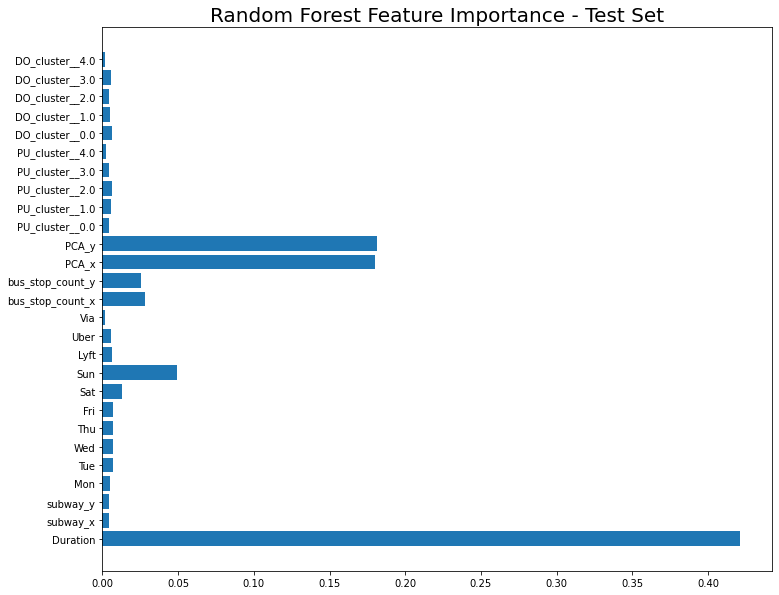

In [25]:
plt.rcParams["figure.figsize"] = (12,10)

plt.barh(X_test.columns[2:], rf.feature_importances_)
plt.title('Random Forest Feature Importance - Test Set', fontsize=20)

In [26]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred)

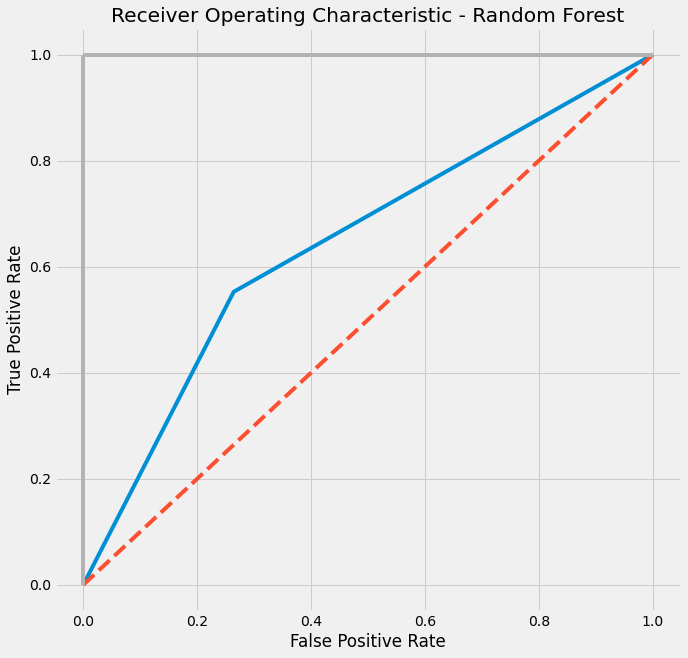

In [27]:
plt.style.use('fivethirtyeight')

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Random Forest')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Model Evalation & Analysis

In [28]:
FinalPred = X_test
FinalPred['Probability'] = pred_proba
FinalPred['Label'] = y_pred

In [32]:
len(FinalPred)

3627524

In [30]:
FinalPred.to_csv('FinalTestPredictions2.csv', index=False)